In [ ]:
# save files
fullproc_r = './resources/' # for words/names

# where to save the figures that are created
#fake_figs_dir = './example_hists/' # saving in github only for small numbers
# stop overwriting what is there
fake_figs_dir = '~/Downloads/tmp/JCDL2025/example_hists/' # large dataset, same format
#fake_figs_dir = '~/LLM_VQA_JCDL2025/example_hists/fewshot/' # for fewshot learning


# format for saving images?
#img_format = ['pdf','jpeg']
img_format = ['jpeg']

# save diagnostic plot with all items labeled?
save_diagnostic_plot = True

# randomize names?
randomize_names = True

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2 as cv
import pickle
import pandas as pd
#import string
from glob import glob
from mpl_toolkits.axes_grid1 import make_axes_locatable
from PIL import ImageColor
import json
import os
from copy import deepcopy
import copy

from utils.metric_utils.utilities import isRectangleOverlap

import time

import matplotlib as mpl
import os
os.environ["PATH"] += os.pathsep + '/Library/TeX/texbin'
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath} \usepackage{amssymb}' #for \text command

# written libs -- will update locally
from utils.synthetic_fig_utils import subset_by_percent, \
 get_nrows_and_ncols, normalize_params_prob, get_ticks, get_titles_or_labels, \
 get_font_info

from utils.plot_utils import get_contour_plot, get_histogram_plot, \
   get_line_plot, get_scatter_plot, make_plot, colorbar_mods#, get_line_plot

from utils.text_utils import get_popular_nouns, get_inline_math

# create a bunch of fake figures
from utils.synthetic_fig_utils import normalize_params_prob
from utils.plot_parameters import plot_types_params, panel_params, \
  title_params, xlabel_params, colorbar_params, \
  ylabel_params, aspect_fig_params, dpi_params, tight_layout_params, \
  fontsizes, base

from utils.data_utils import get_data, NumpyEncoder
import numpy as np

import utils.distribution_utils

from utils.plot_utils import markers, make_base_plot
marker_sizes = np.arange(0,10)+1
line_list_thick = np.arange(1,10)

use_uniques = True # use unique inlines
verbose = True

from sys import path
path.append('/Library/TeX/texbin/')

# debug
from importlib import reload

# for seed
from sys import maxsize as maxint

import warnings
warnings.filterwarnings("error")

In [11]:
# for some versions
fake_figs_dir = os.path.expanduser(fake_figs_dir)
#fake_figs_dir

In [12]:
# check directories
img_dir = fake_figs_dir + '/imgs/'
if not os.path.exists(img_dir):
    os.mkdir(img_dir)
    print('made:', img_dir)
json_dir = fake_figs_dir + '/jsons/'
if not os.path.exists(json_dir):
    os.mkdir(json_dir)
    print('made:', json_dir)

In [13]:
# get fonts -- see "cnn_create_synthetic_ticks" in FullProcess
dfont = pd.read_csv(fullproc_r + 'fonts.csv')

# check that location is there
drop_names = []
for fl in dfont['font location']:
    if not os.path.exists(fl):
        drop_names.append(False)
    else:
        drop_names.append(True)

font_names = dfont.loc[drop_names]['font name'].values

# # for plot styles
# plot_styles = plt.style.available

# plot_types_qa = ['line', 'scatter', 'histogram']

plot_styles = ['default']

In [14]:
# stats for doing calculations
stats = {'minimum':np.min, 'maximum':np.max, 'median':np.median, 'mean':np.mean}

# some things to try
aspect_cut = {'min':0.3, 'max':4.0}

In [15]:
# XYZ -- IS THIS USED NOW??
# get popular words for titles/axis
popular_nouns = get_popular_nouns(fullproc_r + 'data/')

# get inline math formulas
inlines = get_inline_math(fullproc_r,
                          recreate_inlines=False,
                         use_uniques=use_uniques)

16253 343492
shape of output= (5097, 5)
shape of output= (36332, 5)
number of inlines =  33201


## Update plotting params

### Plot type params

In [16]:
plot_params = plot_types_params.copy()

In [17]:
# prob for getting a histogram
plot_params['histogram']['prob'] = 1

# probability of getting a scatter plot
plot_params['scatter']['prob'] = 0
# probability of getting a line
plot_params['line']['prob'] = 0
# prob of getting a contour plot
plot_params['contour']['prob'] = 0

In [19]:
linestyles_hist = ['-'] # only use a subset of the linestyles

plot_params['histogram'] = plot_params['histogram'].copy()

# no horizontal plots
plot_params['histogram']['horizontal prob'] = 0.0

# random distributions
plot_params['histogram']['distribution']['random']['prob'] = 0

# gaussian mixture model
plot_params['histogram']['distribution']['gmm']['prob'] = 1
plot_params['histogram']['distribution']['gmm']['nclusters'] = {'min': 1, 'max': 5}
plot_params['histogram']['distribution']['gmm']['nsamples'] = {'min': 10, 'max': 50}

# linear distributions prob
plot_params['histogram']['distribution']['linear']['prob'] = 1

### Other parameters

In [20]:
# for ease of things, lets not do equations here
title_params['equation']['prob'] = 0.0 # probability any word will be equation
xlabel_params['equation']['prob'] = 0.0 # probability any word will be equation
ylabel_params['equation']['prob'] = 0.0 # probability any word will be equation

Renormalize all probabilities:

In [21]:
# reload for debug
import utils.synthetic_fig_utils
reload(utils)
reload(utils.synthetic_fig_utils)
from utils.synthetic_fig_utils import normalize_params_prob

plot_params_out, panel_params, \
  title_params, xlabel_params, \
  ylabel_params = normalize_params_prob(plot_params.copy(), panel_params, 
                                        title_params, xlabel_params, 
                                        ylabel_params, colorbar_params)

plot_params_out

title_params capatilize did not add to 1! total = 1.2999999999999998
renormalizing...
now:  {'none': 0.07692307692307694, 'first': 0.3846153846153847, 'all': 0.5384615384615385}
xlabel_params capatilize did not add to 1! total = 1.2999999999999998
renormalizing...
now:  {'none': 0.07692307692307694, 'first': 0.3846153846153847, 'all': 0.5384615384615385}
ylabel_params capatilize did not add to 1! total = 1.2999999999999998
renormalizing...
now:  {'none': 0.07692307692307694, 'first': 0.3846153846153847, 'all': 0.5384615384615385}
colorbar_params capatilize did not add to 1! total = 1.2999999999999998
renormalizing...
now:  {'none': 0.07692307692307694, 'first': 0.3846153846153847, 'all': 0.5384615384615385}
plot_types_params['scatter']['color bar']['location probs'] did not add to 1! total = 0.8500000000000001
renormalizing...
now:  {'right': 0.588235294117647, 'left': 0.058823529411764705, 'top': 0.2941176470588235, 'bottom': 0.058823529411764705}
plot_types_params['contour']['color b

{'line': {'prob': 0,
  'npoints': {'min': 10, 'max': 11},
  'line thick': {'min': 1, 'max': 5},
  'nlines': {'min': 2, 'max': 3},
  'xmin': -10000,
  'xmax': 10000,
  'ymin': -10000,
  'ymax': 10000,
  'prob same x': 0.1,
  'markers': {'prob': 0.5, 'size': {'min': 1, 'max': 20}},
  'error bars': {'elinewidth': {'min': 1, 'max': 5},
   'x': {'prob': 0.25, 'size': {'min': 0.01, 'max': 0.1}},
   'y': {'prob': 0.25, 'size': {'min': 0.01, 'max': 0.1}}},
  'distribution': {'random': {'prob': 0.3333333333333333},
   'linear': {'prob': 0.3333333333333333,
    'intersect': (-100, 100),
    'slope': (-5, 5),
    'noise': (0, 0.25)},
   'gmm': {'prob': 0.3333333333333333,
    'histogram as line': {'prob': 0.25, 'factor': 1000},
    'nclusters': {'min': 1, 'max': 20},
    'nsamples': {'min': 10, 'max': 500},
    'cluster std': {'min': -2, 'max': 0.5},
    'noise': {'min': 0.05, 'max': 0.25}}}},
 'histogram': {'prob': 1,
  'npoints': {'min': 10, 'max': 10000},
  'nbins': {'min': 1, 'max': 100},
  '

### Run the thing

In [22]:
# Set a seed if you want a reproducible thing
seed_outer = np.random.randint(maxint)
#seed_outer = 7526304181034464103
seed_outer = 6700012876856450103

print('seed_outer =',seed_outer)
rng_outer = np.random.default_rng(seed_outer)

seed_outer = 6700012876856450103


In [23]:
# "Inner" seed -- for things like distributions and whatnot
seed = np.random.randint(maxint)
#seed = 2870146871786070273
seed = 7067533564274193147
print('seed = ', seed)
# based on seed, make random number generator, see: https://numpy.org/doc/2.2/reference/random/generator.html
rng = np.random.default_rng(seed)
condition_overlap_xticklabels = True

seed =  7067533564274193147


In [24]:
# set some things to keep standard across images

tight_layout = True

color_map = 'Blues' #rng_outer.choice(plt.colormaps())

plot_style = 'default' #rng_outer.choice(plot_styles)

npanels, panel_style, nrows, ncols = 1, 'square', 1, 1 #get_nrows_and_ncols(panel_params, rng=rng_outer)

aspect_fig = 0.9

dpi =  300 # int(rng_outer.uniform(low=dpi_params['min'], high=dpi_params['max']))

In [25]:
# use the "fixed" RNG outer
# get all font stuffs
title_fontsize, colorbar_fontsize, xlabel_fontsize, ylabel_fontsize, \
    xlabel_ticks_fontsize, ylabel_ticks_fontsize, \
                        csfont = get_font_info(fontsizes, font_names, rng=rng_outer)

In [26]:
choices = []; probs = []
for k,v in plot_params_out.items():
    choices.append(k)
    probs.append(v['prob'])

plot_type = rng.choice(choices, p=probs)
plot_type

np.str_('histogram')

In [27]:
distribution_type = 'gmm'
xmin, xmax = -1, 1 # for now

# now specific for *this plot*
plot_params_here = plot_params_out.copy()

plot_params_here['histogram']['xmin'] = xmin
plot_params_here['histogram']['xmax'] = xmax

plot_params_here['histogram']['distribution']['gmm']['nclusters'] = {'min': 1, 'max': 1}
plot_params_here['histogram']['distribution']['gmm']['nsamples'] = {'min': 10000, 'max': 10000}
#plot_params_here['histogram']['distribution']['gmm']['xmin'] = xmin # are these even used??
#plot_params_here['histogram']['distribution']['gmm']['xmax'] = xmax # are these even used??

dist_params = plot_params_here[plot_type]['distribution'] 

In [28]:
dist_params

{'random': {'prob': 0.0},
 'linear': {'prob': 0.5,
  'intersect': (-100, 100),
  'slope': (-5, 5),
  'noise': (0, 0.25)},
 'gmm': {'prob': 0.5,
  'xmin': -10000,
  'xmax': 10000,
  'ymin': -10000,
  'ymax': 10000,
  'nclusters': {'min': 1, 'max': 1},
  'nsamples': {'min': 10000, 'max': 10000},
  'cluster std': {'min': -1, 'max': 1.5},
  'noise': {'min': 0.05, 'max': 0.25}}}

In [29]:
import utils.distribution_utils
import utils.data_utils
reload(utils.distribution_utils)
reload(utils.data_utils)
from utils.data_utils import get_data
import utils.plot_classes_utils
reload(utils.plot_classes_utils)

seed = np.random.randint(maxint)
print('seed = ', seed)
rng = np.random.default_rng(seed)

data_for_plot = get_data(plot_params_here[plot_type],
                plot_type=plot_type,
                        distribution=distribution_type, 
                        rng=rng)
data_for_plot

seed =  6143691119185830407


{'xs': array([0.12586165, 0.19199598, 0.00782694, ..., 0.0417769 , 0.09382035,
        0.20712544], shape=(1932,)),
 'ys': [],
 'xerrs': True,
 'data params': {'nsamples': 10000,
  'nclusters': 1,
  'centers': array([[0.05741845]]),
  'cluster_std': array([0.54006003]),
  'noise level': 0.09526017344755977}}

In [30]:
str(plot_type)

'histogram'

In [31]:
from utils.synthetic_fig_utils import add_titles_and_labels

import utils.plot_utils
import utils.data_utils
import utils.plot_classes_utils
reload(utils.plot_classes_utils)
reload(utils.data_utils)
reload(utils.plot_utils)
from utils.plot_utils import make_plot, make_base_plot
from utils.data_utils import get_data

figsize (w,h) = (2.666, 2)


<Figure size 640x480 with 0 Axes>

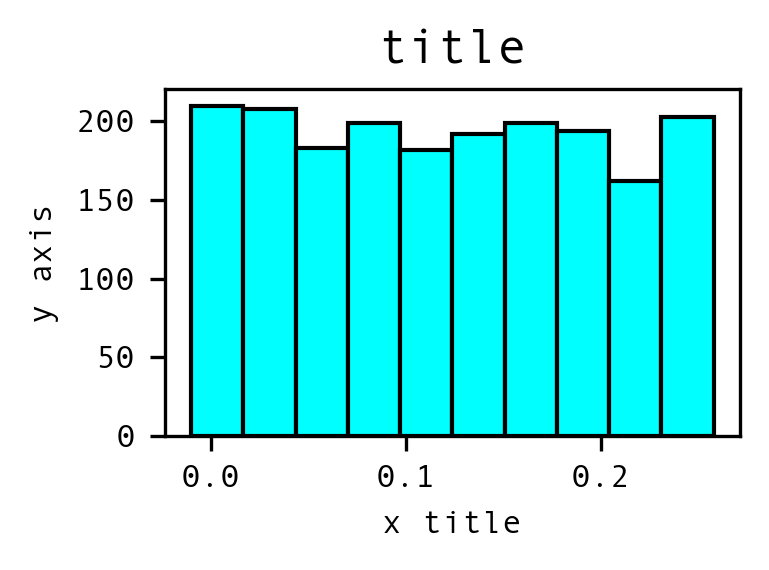

In [32]:
aspect_fig = 1.333

fig, axes, plot_inds = make_base_plot(plot_style, color_map, dpi, nrows, ncols, aspect_fig,
                   base=2, verbose=True, tight_layout = tight_layout)

data_from_plot, ax = make_plot(plot_params_here[plot_type], data_for_plot, 
                        axes[0], plot_type=plot_type, linestyles=linestyles_hist, 
                        rng=rng, 
                        barcolor='cyan', linecolor=(0,0,0), hasErr = False, lthick=1, nbins=10, rwidth=1.0)

title, xlabel, ylabel = add_titles_and_labels(axes[0], 'x title', 'y axis', 'title', 
                                              title_params, csfont, title_fontsize, 
                          xlabel_params, ylabel_params, xlabel_fontsize, ylabel_fontsize,
                          inlines, xlabel_ticks_fontsize, ylabel_ticks_fontsize,
                          rng=rng)

In [33]:
data_for_plot

{'xs': array([0.12586165, 0.19199598, 0.00782694, ..., 0.0417769 , 0.09382035,
        0.20712544], shape=(1932,)),
 'ys': [],
 'xerrs': True,
 'data params': {'nsamples': 10000,
  'nclusters': 1,
  'centers': array([[0.05741845]]),
  'cluster_std': array([0.54006003]),
  'noise level': 0.09526017344755977}}

In [34]:
data_from_plot

{'data': (array([210., 208., 183., 199., 182., 192., 199., 194., 162., 203.]),
  array([-0.01020416,  0.01658768,  0.04337952,  0.07017137,  0.09696321,
          0.12375505,  0.15054689,  0.17733874,  0.20413058,  0.23092242,
          0.25771426]),
  <BarContainer object of 10 artists>),
 'plot params': {'linethick': 1,
  'linestyles': np.str_('-'),
  'bar color': 'cyan',
  'edge color': [array([0, 0, 0])],
  'orientation': 'vertical',
  'rwidth': 1.0,
  'nbins': 10}}

Loop for several distributions and save:

In [35]:
import utils.histogram_plot_qa_utils
reload(utils.histogram_plot_qa_utils)

from utils.histogram_plot_qa_utils import q_nbars_hist_plot_plotnums, q_stats_hists, q_gmm_ngaussians_hists

In [36]:
import utils.synthetic_fig_utils
reload(utils.synthetic_fig_utils)
from utils.synthetic_fig_utils import collect_plot_data_axes

In [37]:
import utils.plot_qa_utils
reload(utils.plot_qa_utils)
from utils.plot_qa_utils import init_qa_pairs

QUESTION: You are a helpful assistant that can analyze images.  How many bars are there in the specified figure panel? Please format the output as a json as {"nbars":""} for this figure panel, where the "nbars" value should be an integer.
ANSWER: {'nbars': 40}
QUESTION: You are a helpful assistant that can analyze images.  What are the minimum data values  in this figure panel?  Please format the output as a json as {"minimum x":""} for this figure panel, where the "minimum x" value should be a float, calculated from the data values used to create the plot.
ANSWER: {'minimum': {'plot0': {'minimum x': 0.13900026617122288}}}
QUESTION: You are a helpful assistant that can analyze images.  What are the maximum data values  in this figure panel?  Please format the output as a json as {"maximum x":""} for this figure panel, where the "maximum x" value should be a float, calculated from the data values used to create the plot.
ANSWER: {'maximum': {'plot0': {'maximum x': 0.8639469354197858}}}


<Figure size 640x480 with 0 Axes>

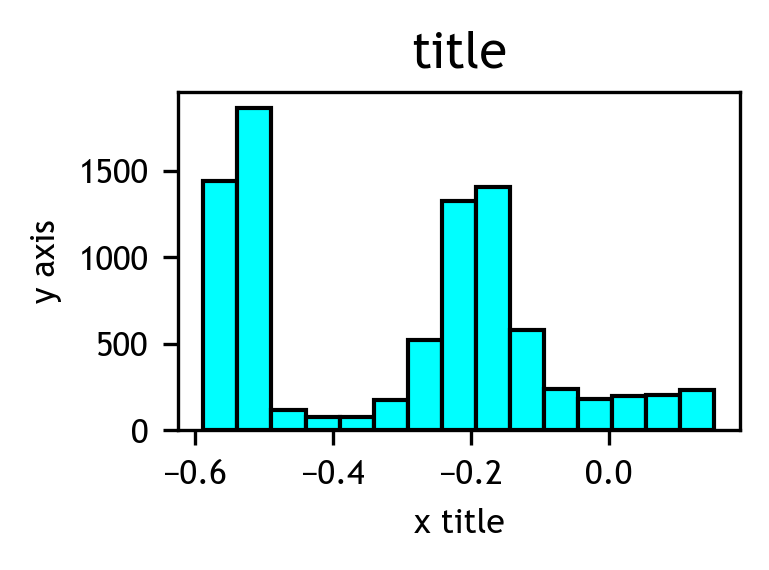

In [ ]:
# Maybe different number of bars?: 10, 20, 50 – fix number of gaussians at 2
# Maybe different number of gaussians? 1, 2, 3, 5 – fix bars at 50


# for ID pairs
if randomize_names:
    id_pairs = {'ids':[], 'ncluster':[], 'nbars':[]}


# for main run
# nparams = [
#     {'nb':10, 'nc':2},
#     {'nb':20, 'nc':2},
#     {'nb':45, 'nc':2},
#     {'nb':60, 'nc':2}, # updated so no overlap
#     # different set
#     {'nb':50, 'nc':1},
#     {'nb':50, 'nc':2}, 
#     {'nb':50, 'nc':3},
#     {'nb':50, 'nc':5}
# ]
#ntrials = 10

# for fewshot
nparams = [
    # different set
    {'nb':40, 'nc':1},
    {'nb':40, 'nc':2}, 
    {'nb':40, 'nc':5},
    {'nb':15, 'nc':1},
    {'nb':15, 'nc':2}, 
    {'nb':15, 'nc':3}
    ]
ntrials = 1




cluster_std = {'min':-2, 'max':0.0} # in 10^

noise = {'min': 0.05, 'max': 0.1}

plot_json = []


verbose_qa = True

# check for github
if 'LLM_VQA_JCDL2025' in fake_figs_dir and ntrials > 10:
    print('Limiting trials for saving in github.  Change the "fake_figs_dir" param to a local address')
    ntrials = 10


# grab IDs
ids = []
ids_possible = np.linspace(0,len(nparams)*ntrials-1, len(nparams)*ntrials).astype('int')
np.random.shuffle(ids_possible)
id_count = 0
for n in range(ntrials):
    for nparam in nparams:
        nclust = nparam['nc']
        nbins = nparam['nb']

        # id_here = np.random.randint(0, 9999)
        # while id_here in ids: # make sure unique
        #     id_here = np.random.randint(0, 9999)
        # ids.append(id_here)

        id_here = ids_possible[id_count]
        id_count += 1
        id_pairs['ids'].append(id_here)
        id_pairs['ncluster'].append(nclust)
        id_pairs['nbars'].append(nbins)

        # this becomes more important when we have multiple axes and more complex plots
        data_for_plots = []
        plot_types = []
        data_from_plots = []
        titles = []; xlabels = []; ylabels = []; 
        cbars = []; cbar_labels = []; cbar_words = []; cbar_nums = []
        end_time = time.time()
        distribution_types = []
        # in case axes change
        axes_save = []; cbar_axes_save = []

        plot_params_loop = plot_params_here.copy()
        plot_params_loop['histogram']['distribution']['gmm']['nclusters'] = {'min': nclust, 'max': nclust}
        plot_params_loop['histogram']['distribution']['gmm']['cluster std'] = cluster_std
        plot_params_loop['histogram']['distribution']['gmm']['noise'] = noise
        data_for_plot = get_data(plot_params_loop[plot_type],
                        plot_type=plot_type,
                                distribution=distribution_type, 
                                rng=rng)
        # pltjson = {}
        # pltjson['nclusters'] = nclust
        # pltjson['data for plot'] = data_for_plot.copy()

        # fig, axes, plot_inds = make_base_plot(plot_style, color_map, dpi, nrows, ncols, 
        #             base=2, verbose=False, tight_layout = tight_layout)
        fig, axes, plot_inds = make_base_plot(plot_style, color_map, dpi, 
                                              nrows, ncols, aspect_fig,
                        base=2, verbose=False, tight_layout = tight_layout)

        for iplot, ax in enumerate(axes):
            data_from_plot, ax = make_plot(plot_params_loop[plot_type], data_for_plot, 
                                    ax, plot_type=plot_type, linestyles=linestyles_hist, 
                                    rng=rng, 
                                    barcolor='cyan', linecolor=(0,0,0), hasErr = False, lthick=1, nbins=nbins, rwidth=1.0)
            #pltjson['data from plot'] = data_from_plot.copy()

            # add title/x/y labels
            # title, xlabel, ylabel = add_titles_and_labels(ax, 'x title', 'y axis', 'title', 
            #                                     title_params, csfont, title_fontsize, 
            #                 xlabel_params, inlines, xlabel_ticks_fontsize, ylabel_ticks_fontsize,
            #                 rng=rng)
            title, xlabel, ylabel = add_titles_and_labels(axes[0], 'x title', 'y axis', 'title', 
                                                        title_params, csfont, title_fontsize, 
                                    xlabel_params, ylabel_params, xlabel_fontsize, ylabel_fontsize,
                                    inlines, xlabel_ticks_fontsize, ylabel_ticks_fontsize,
                                    rng=rng)

            # save image
            base_name = 'nclust_' + str(nclust) + '_trial' + str(n)
            if randomize_names:
                base_name = 'id_' + str(id_here).zfill(4)
            for imgf in img_format:
                fig.savefig(img_dir + base_name + '.' + imgf)

            ####### SAVE DATA ########
            # save data for parsing later -- only a single plot right now
            data_for_plots.append(data_for_plot)
            plot_types.append(plot_type)
            data_from_plots.append(data_from_plot)
            titles.append(title)
            xlabels.append(xlabel)
            ylabels.append(ylabel)
            distribution_types.append(distribution_type)

        fig.canvas.draw()
        width, height = fig.canvas.get_width_height()
        # save data
        datas = {}
        # figure datas
        datas['figure'] = {'dpi':dpi, 'base':base, 'aspect ratio': aspect_fig, 
                            'nrows':nrows, 'ncols':ncols, 
                            'plot style':plot_style, 
                            'color map':color_map,
                            'title fontsize':title_fontsize, 
                            'xlabel fontsize':xlabel_fontsize,
                            'ylabel fontsize':ylabel_fontsize, 
                        'plot indexes':plot_inds}
        for iplot,ax in enumerate(axes): ### XYZ, colorbar
            # datas['plot' + str(iplot)] = collect_plot_data_axes(ax, 
            #                height, width,
            #                data_from_plots[iplot], data_for_plots[iplot], 
            #                plot_types[iplot], titles[iplot], 
            #                xlabels[iplot], ylabels[iplot],
            #                distribution_types[iplot], verbose=True)
            datas['plot' + str(iplot)] = collect_plot_data_axes(ax, fig,
                           height, width,
                           data_from_plots[iplot], data_for_plots[iplot], 
                           plot_types[iplot], titles[iplot], 
                           xlabels[iplot], ylabels[iplot],
                           distribution_types[iplot], verbose=True)#, 
                           #cbar_label=cbar_labels[iplot], cbar_word=cbar_words[iplot], 
                           #cbar_ax=cbar_ax)
            

        ######## GENERATE QA BASE #######
        qa_pairs = init_qa_pairs()
        for iplot in range(len((axes))):
            if datas['plot'+str(iplot)]['type'] == 'histogram':
                ############ L1 #############
                # number of bars
                if len(axes) > 1:
                    qa_pairs = q_nbars_hist_plot_plotnums(datas, qa_pairs, plot_num = iplot, use_words=False, verbose=verbose_qa)
                qa_pairs = q_nbars_hist_plot_plotnums(datas, qa_pairs, plot_num = iplot, use_words=True, verbose=verbose_qa)

                ###### L2 #######
                # stats items
                for k,v in stats.items():
                    if len(axes) > 1:
                        qa_pairs = q_stats_hists(datas, qa_pairs, stat={k:v}, plot_num=iplot, use_words=False, verbose=verbose_qa)
                    qa_pairs = q_stats_hists(datas, qa_pairs, stat={k:v}, plot_num=iplot, use_words=True, verbose=verbose_qa)

                ###### L3 ######
                # if GMM -- how many gaussians?
                hasGMM = False
                if 'data params' not in datas['plot'+str(iplot)]['data']:
                    #print('Not a gmm relationship!')
                    pass
                else:
                    if datas['plot'+str(iplot)]['distribution'] == 'gmm':
                        hasGMM = True
                if hasGMM:       
                    qa_pairs = q_gmm_ngaussians_hists(datas, qa_pairs, plot_num=iplot, use_words=True, verbose=verbose_qa)

        datas['VQA'] = qa_pairs


        #import sys; sys.exit()

        # dump full data
        dumped = json.dumps(datas, cls=NumpyEncoder)
        with open(json_dir + base_name + '.json', 'w') as f:
            json.dump(dumped, f)

        #plot_json.append(pltjson.copy())
# save randomized file
if randomize_names:
    df_ids = pd.DataFrame(id_pairs)
    df_ids.to_csv(fake_figs_dir + 'randomized_trials.csv', index=False)
    

In [95]:
ids_possible = np.linspace(0,len(nparams)*ntrials-1, len(nparams)*ntrials).astype('int')
np.random.shuffle(ids_possible)
len(ids_possible)

80

In [96]:
ids_possible

array([18, 36, 58, 29, 67, 61, 37, 79,  5, 74, 49, 66, 23,  3,  9, 11, 72,
       56, 42, 46, 26, 28, 16,  2, 33, 19, 40, 62, 21, 65,  6, 76, 17, 45,
       53, 73, 71, 57,  0, 55, 64, 31, 13,  8, 32, 10, 30, 43, 20, 44, 70,
       51, 47, 14, 77, 75, 35, 54, 15,  7, 63, 69, 38, 22, 68,  1, 25, 48,
       24, 39,  4, 12, 27, 60, 59, 50, 41, 78, 34, 52])

Practice reading in:

In [65]:
import json
data_file = json_dir + 'nclust_4_trial8.json'
with open(data_file,'r') as f:
    t = json.load(f)
    datas = json.loads(t)

In [38]:
datas['VQA']

{'Level 1': {'Figure-level questions': {},
  'Plot-level questions': {'nbars ': {'plot0': {'Q': 'You are a helpful assistant that can analyze images.  How many bars are there in the specified figure panel? Please format the output as a json as {"nbars":""} for this figure panel, where the "nbars" value should be an integer.',
     'A': {'nbars ': 50},
     'persona': 'You are a helpful assistant that can analyze images.',
     'context': '',
     'question': 'How many bars are there in the specified figure panel?',
     'format': 'Please format the output as a json as {"nbars":""} for this figure panel, where the "nbars" value should be an integer.'}}}},
 'Level 2': {'Plot-level questions': {'minimum ': {'plot0': {'Q': 'You are a helpful assistant that can analyze images.  What are the minimum data values in this figure panel?  Please format the output as a json as {"minimum x":""} for this figure panel, where the "minimum" value should be a float, calculated from the data values used 

In [66]:
datas['VQA']['Level 1']['Plot-level questions']

{'nbars ': {'plot0': {'Q': 'You are a helpful assistant that can analyze images.  How many bars are there in the specified figure panel? Please format the output as a json as {"nbars":""} for this figure panel, where the "nbars" value should be an integer.',
   'A': {'nbars ': 50},
   'persona': 'You are a helpful assistant that can analyze images.',
   'context': '',
   'question': 'How many bars are there in the specified figure panel?',
   'format': 'Please format the output as a json as {"nbars":""} for this figure panel, where the "nbars" value should be an integer.'}}}